# Pix2Pix

* `Image-to-Image Translation with Conditional Adversarial Networks`, [arXiv:1611.07004](https://arxiv.org/abs/1611.07004)
  * Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, and Alexei A. Efros
  
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and [`eager execution`](https://www.tensorflow.org/guide/eager).
* This code is borrowed from [TensorFlow Tutorial code](https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/contrib/eager/python/examples/pix2pix/pix2pix_eager.ipynb)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
train_dir = 'train/pix2pix/exp1/'
model_name = 'pix2pix'
max_epochs = 200
save_model_epochs = 20
print_steps = 50
save_images_epochs = 5
batch_size = 1
learning_rate_D = 2e-4
learning_rate_G = 2e-4
N = 400 # number of samples in train_dataset

BUFFER_SIZE = N
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 100

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [3]:
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      cache_subdir=os.path.abspath('../datasets'),
                                      origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz', 
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

## Set up dataset with `tf.data`

In [4]:
def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  if is_train:
    # random jittering
    
    # resizing to 286 x 286 x 3
    input_image = tf.image.resize_images(input_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 x 256 x 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if np.random.random() > 0.5:
      # random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                        align_corners=True, method=2)
  
  # normalizing the images to [-1, 1]
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

### Use tf.data to create batches, map(do preprocessing) and shuffle the dataset

In [5]:
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(batch_size)

In [6]:
test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(batch_size)

## Write the generator and discriminator models

* **Generator**
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).

* **Discriminator**
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))
  * Shape of the input travelling through the generator and the discriminator is in the comments in the code.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

In [7]:
class Downsample(tf.keras.Model):
  def __init__(self, filters, size, apply_batchnorm=True):
    super(Downsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    self.conv1 = layers.Conv2D(filters=filters,
                               kernel_size=(size, size), 
                               strides=2, 
                               padding='same',
                               kernel_initializer=tf.random_normal_initializer(0., 0.02),
                               use_bias=False)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    
    return x

In [8]:
class Upsample(tf.keras.Model):
  def __init__(self, filters, size, apply_dropout=False):
    super(Upsample, self).__init__()
    self.apply_dropout = apply_dropout
    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(size, size),
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    if self.apply_dropout:
      self.dropout = layers.Dropout(0.5)

  def call(self, x1, x2, training):
    x = self.up_conv(x1)
    x = self.batchnorm(x, training=training)
    if self.apply_dropout:
      x = self.dropout(x, training=training)
    x = tf.nn.relu(x)
    x = tf.concat([x, x2], axis=-1)
    
    return x

In [9]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.down1 = Downsample(64, 4, apply_batchnorm=False)
    self.down2 = Downsample(128, 4)
    self.down3 = Downsample(256, 4)
    self.down4 = Downsample(512, 4)
    self.down5 = Downsample(512, 4)
    self.down6 = Downsample(512, 4)
    self.down7 = Downsample(512, 4)
    self.down8 = Downsample(512, 4)

    self.up1 = Upsample(512, 4, apply_dropout=True)
    self.up2 = Upsample(512, 4, apply_dropout=True)
    self.up3 = Upsample(512, 4, apply_dropout=True)
    self.up4 = Upsample(512, 4)
    self.up5 = Upsample(256, 4)
    self.up6 = Upsample(128, 4)
    self.up7 = Upsample(64, 4)

    self.last = layers.Conv2DTranspose(filters=3,
                                       kernel_size=(4, 4),
                                       strides=2,
                                       padding='same',
                                       kernel_initializer=tf.random_normal_initializer(0., 0.02))
  
  @tf.contrib.eager.defun
  def call(self, x, training):
    # x shape == (bs, 256, 256, 3)    
    x1 = self.down1(x, training=training) # (bs, 128, 128, 64)
    x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
    x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
    x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
    x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
    x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
    x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
    x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

    x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
    x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
    x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
    x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
    x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
    x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
    x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

    x16 = self.last(x15) # (bs, 256, 256, 3)
    generated_images = tf.nn.tanh(x16)

    return generated_images

In [10]:
class DiscDownsample(tf.keras.Model):
  def __init__(self, filters, size, apply_batchnorm=True):
    super(DiscDownsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    self.conv1 = layers.Conv2D(filters=filters,
                               kernel_size=(size, size),
                               strides=2,
                               padding='same',
                               kernel_initializer=tf.random_normal_initializer(0., 0.02),
                               use_bias=False)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)

    return x

In [11]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()    
    self.down1 = DiscDownsample(64, 4, False)
    self.down2 = DiscDownsample(128, 4)
    self.down3 = DiscDownsample(256, 4)
    
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    self.zero_pad1 = layers.ZeroPadding2D()
    self.conv = layers.Conv2D(filters=512,
                              kernel_size=(4, 4),
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=False)
    self.batchnorm1 = layers.BatchNormalization()
    
    # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
    self.zero_pad2 = layers.ZeroPadding2D()
    self.last = layers.Conv2D(filters=1,
                              kernel_size=(4, 4),
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))
  
  @tf.contrib.eager.defun
  def call(self, inputs, targets, training):
    # concatenating the input and the target
    x = tf.concat([inputs, targets], axis=-1) # (bs, 256, 256, channels*2)
    x = self.down1(x, training=training) # (bs, 128, 128, 64)
    x = self.down2(x, training=training) # (bs, 64, 64, 128)
    x = self.down3(x, training=training) # (bs, 32, 32, 256)

    x = self.zero_pad1(x) # (bs, 34, 34, 256)
    x = self.conv(x)      # (bs, 31, 31, 512)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.leaky_relu(x)
    
    x = self.zero_pad2(x) # (bs, 33, 33, 512)
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    x = self.last(x)      # (bs, 30, 30, 1)

    return x

In [12]:
# The call function of Generator and Discriminator have been decorated
# with tf.contrib.eager.defun()
# We get a performance speedup if defun is used (~25 seconds per epoch)
generator = Generator()
discriminator = Discriminator()

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; real images, generated images
  * real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
  * generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
  * Then the total_loss is the sum of real_loss and the generated_loss
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an array of ones.
  * The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [13]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`1-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  return tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                         logits=logits)

In [14]:
def discriminator_loss(real_logits, fake_logits):
#def discriminator_loss(disc_real_output, disc_generated_output):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [15]:
def generator_loss(fake_logits, gen_output, target):
  # losses of Generator with label "1" that used to fool the Discriminator
  gan_loss = GANLoss(logits=fake_logits, is_real=True)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  return gan_loss + (LAMBDA * l1_loss)

In [16]:
#discriminator_optimizer = tf.train.RMSPropOptimizer(learning_rate_D)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate_D, beta1=0.5)
generator_optimizer = tf.train.AdamOptimizer(learning_rate_G, beta1=0.5)

## Checkpoints (Object-based saving)

In [17]:
checkpoint_dir = train_dir
if not tf.gfile.Exists(checkpoint_dir):
  tf.gfile.MakeDirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [18]:
def print_or_save_sample_images(test_input, target, prediction,
                                is_save=False, epoch=None, checkpoint_dir=checkpoint_dir):
  plt.figure(figsize=(15, 5))
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

  display_list = [test_input[0], target[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  if is_save and epoch is not None:
    filepath = os.path.join(checkpoint_dir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig(filepath)
    
  plt.show() 

In [19]:
# keeping the constant test input for generation (prediction) so
# it will be easier to see the improvement of the pix2pix.
for inputs, targets in test_dataset.take(1):
  constant_test_input = inputs
  constant_test_target = targets

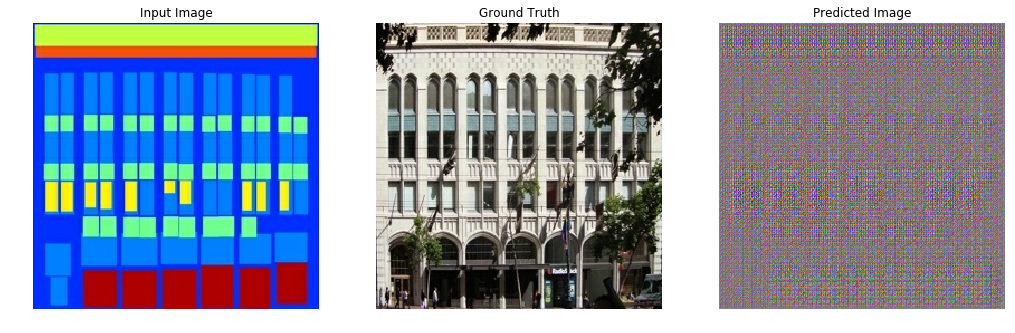

In [20]:
# Check for test data
prediction = generator(constant_test_input, training=True)
print_or_save_sample_images(constant_test_input, constant_test_target, prediction)

This images are saved at 200 epoch


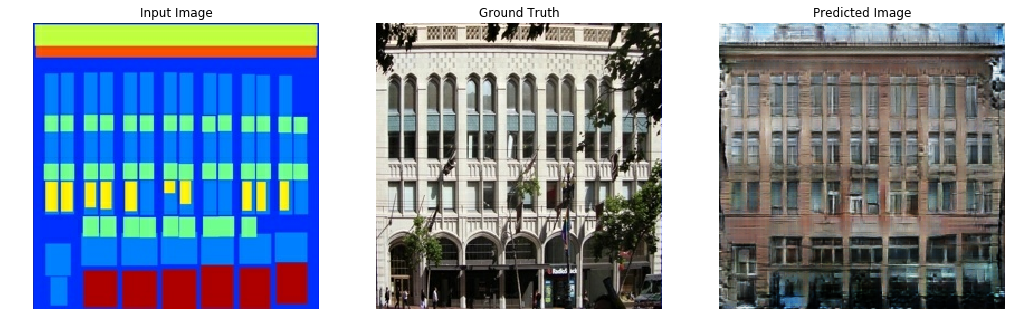

In [21]:
tf.logging.info('Start Training.')
global_step = tf.train.get_or_create_global_step()
for epoch in range(max_epochs):
  
  for input_images, target in train_dataset:
    start_time = time.time()
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(input_images, training=True)

      real_logits = discriminator(input_images, target, training=True)
      fake_logits = discriminator(input_images, generated_images, training=True)

      gen_loss = generator_loss(fake_logits, generated_images, target)
      disc_loss = discriminator_loss(real_logits, fake_logits)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables),
                                        global_step=global_step)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
        
    epochs = global_step.numpy() * batch_size / float(N)
    duration = time.time() - start_time

    if global_step.numpy() % print_steps == 0:
      display.clear_output(wait=True)
      examples_per_sec = batch_size / float(duration)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, examples_per_sec, duration))
      # generate sample image from random test image
      # the training=True is intentional here since
      # we want the batch statistics while running the model
      # on the test dataset. If we use training=False, we will get 
      # the accumulated statistics learned from the training dataset
      # (which we don't want)
      for test_input, test_target in test_dataset.take(1):
        prediction = generator(test_input, training=True)
        print_or_save_sample_images(test_input, test_target, prediction)

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    prediction = generator(constant_test_input, training=True)
    print_or_save_sample_images(constant_test_input, constant_test_target, prediction,
                                is_save=True, epoch=epoch+1, checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

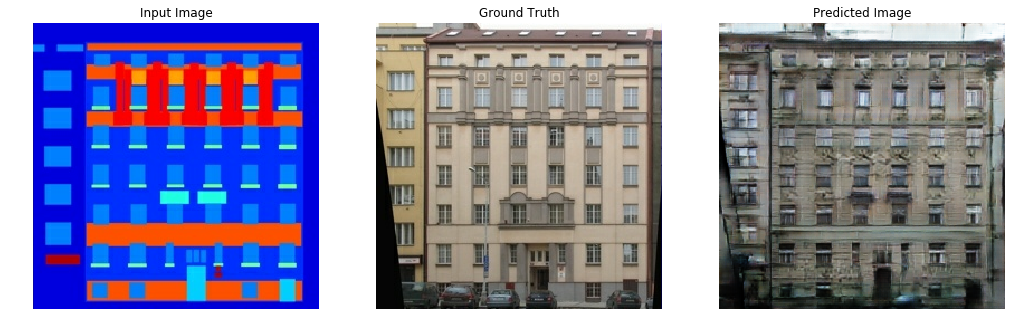

In [22]:
# generating after the final epoch
display.clear_output(wait=True)
for test_input, target in test_dataset.take(1):
  prediction = generator(test_input, training=True)
  print_or_save_sample_images(test_input, target, prediction)

## Restore the latest checkpoint

In [23]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [24]:
def display_image(epoch_no, checkpoint_dir=checkpoint_dir):
  filepath = os.path.join(checkpoint_dir, 'image_at_epoch_{:04d}.png'.format(epoch_no))
  return PIL.Image.open(filepath)

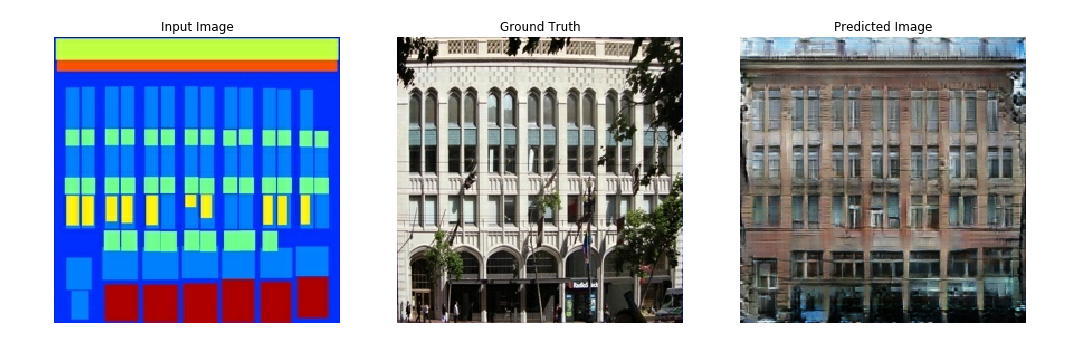

In [25]:
display_image(max_epochs)

## Generate a GIF of all the saved images.

In [26]:
with imageio.get_writer(model_name + '.gif', mode='I') as writer:
  filenames = glob.glob(os.path.join(checkpoint_dir, 'image*.png'))
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp {}.gif {}.gif.png'.format(model_name, model_name))

0

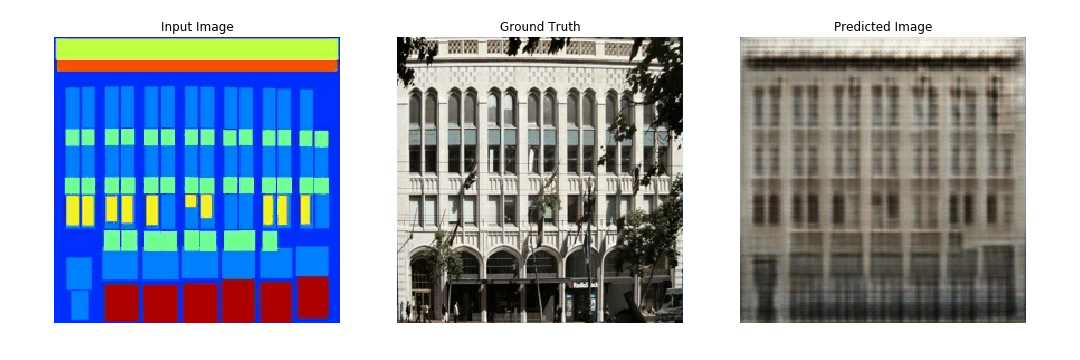

In [27]:
display.Image(filename=model_name + ".gif.png")